In [17]:
%load_ext autoreload

In [18]:
%autoreload 2

## Imports

In [1]:
import pyspark
from pyspark.sql.functions import col
from ifood_case.data_visualizer import DataVisualizer

## Initialize Spark

In [2]:
spark = pyspark.sql.SparkSession.builder.appName("ifood-case").getOrCreate()

25/09/20 19:13:37 WARN Utils: Your hostname, solid resolves to a loopback address: 127.0.0.2; using 192.168.0.39 instead (on interface enp5s0)
25/09/20 19:13:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/20 19:13:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Data 

In [3]:
offers = spark.read.json("../data/raw/offers.json")
transactions = spark.read.json("../data/raw/transactions.json")
profile = spark.read.json("../data/raw/profile.json")

## Data Exploration

In [4]:
offers.show(20,truncate=False)

+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|channels                    |discount_value|duration|id                              |min_value|offer_type   |
+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|[email, mobile, social]     |10            |7.0     |ae264e3637204a6fb9bb56bc8210ddfd|10       |bogo         |
|[web, email, mobile, social]|10            |5.0     |4d5c57ea9a6940dd891ad53e9dbe8da0|10       |bogo         |
|[web, email, mobile]        |0             |4.0     |3f207df678b143eea3cee63160fa8bed|0        |informational|
|[web, email, mobile]        |5             |7.0     |9b98b8c7a33c4b65b9aebfe6a799e6d9|5        |bogo         |
|[web, email]                |5             |10.0    |0b1e1539f2cc45b7b9fa7c272da2e1d7|20       |discount     |
|[web, email, mobile, social]|3             |7.0     |2298d6c36e964ae4a3e7e9706d1fb8c2|7        |discoun

In [5]:
transactions.show(5, truncate=False)

[Stage 4:>                                                          (0 + 1) / 1]

+--------------------------------+--------------+---------------------+----------------------------------------------------+
|account_id                      |event         |time_since_test_start|value                                               |
+--------------------------------+--------------+---------------------+----------------------------------------------------+
|78afa995795e4d85b5d9ceeca43f5fef|offer received|0.0                  |{NULL, 9b98b8c7a33c4b65b9aebfe6a799e6d9, NULL, NULL}|
|a03223e636434f42ac4c3df47e8bac43|offer received|0.0                  |{NULL, 0b1e1539f2cc45b7b9fa7c272da2e1d7, NULL, NULL}|
|e2127556f4f64592b11af22de27a7932|offer received|0.0                  |{NULL, 2906b810c7d4411798c6938adc9daaa5, NULL, NULL}|
|8ec6ce2a7e7949b1bf142def7d0e0586|offer received|0.0                  |{NULL, fafdcd668e3743c1bb461111dcafc2a4, NULL, NULL}|
|68617ca6246f4fbc85e91a2a49552598|offer received|0.0                  |{NULL, 4d5c57ea9a6940dd891ad53e9dbe8da0, NULL, NULL}|


In [6]:
profile.show(5, truncate=False)

+---+-----------------+------+--------------------------------+-------------+
|age|credit_card_limit|gender|id                              |registered_on|
+---+-----------------+------+--------------------------------+-------------+
|118|NULL             |NULL  |68be06ca386d4c31939f3a4f0e3dd783|20170212     |
|55 |112000.0         |F     |0610b486422d4921ae7d2bf64640c50b|20170715     |
|118|NULL             |NULL  |38fe809add3b4fcf9315a9694bb96ff5|20180712     |
|75 |100000.0         |F     |78afa995795e4d85b5d9ceeca43f5fef|20170509     |
|118|NULL             |NULL  |a03223e636434f42ac4c3df47e8bac43|20170804     |
+---+-----------------+------+--------------------------------+-------------+
only showing top 5 rows



In [7]:
profile.filter(col("gender").isNull()).show()

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|
|118|             NULL|  NULL|8ec6ce2a7e7949b1b...|     20170925|
|118|             NULL|  NULL|68617ca6246f4fbc8...|     20171002|
|118|             NULL|  NULL|8974fc5686fe429db...|     20161122|
|118|             NULL|  NULL|c4863c7985cf408fa...|     20170824|
|118|             NULL|  NULL|148adfcaa27d485b8...|     20150919|
|118|             NULL|  NULL|744d603ef08c4f33a...|     20170801|
|118|             NULL|  NULL|2b826eba31074a059...|     20170907|
|118|             NULL|  NULL|65aba5c617294649a...|     20170330|
|118|             NULL|  NULL|4beeb3ed64dd4898b...|     20160707|
|118|     

In [8]:
transactions.select("event").distinct().collect()

[Row(event='transaction'),
 Row(event='offer received'),
 Row(event='offer completed'),
 Row(event='offer viewed')]

In [9]:
data_visualizer = DataVisualizer(offers, transactions, profile)

## Univariate Analysis 

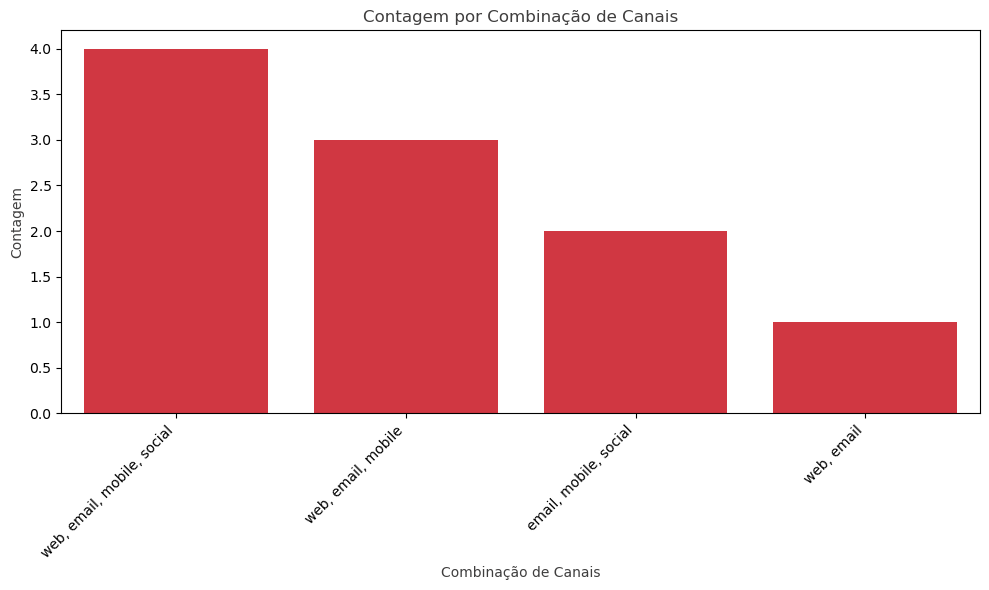

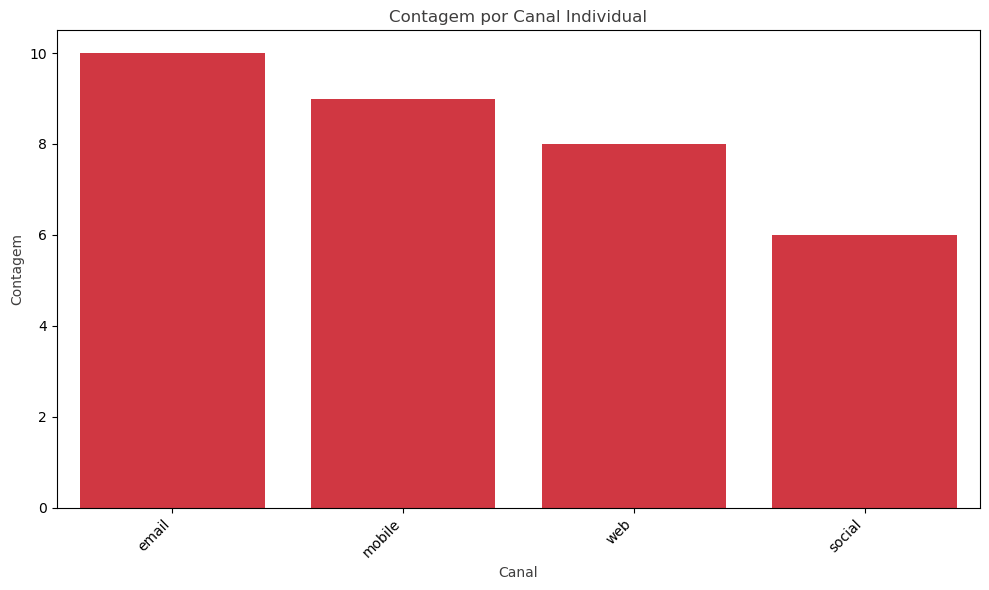

In [10]:
data_visualizer.plot_barplot_channels()

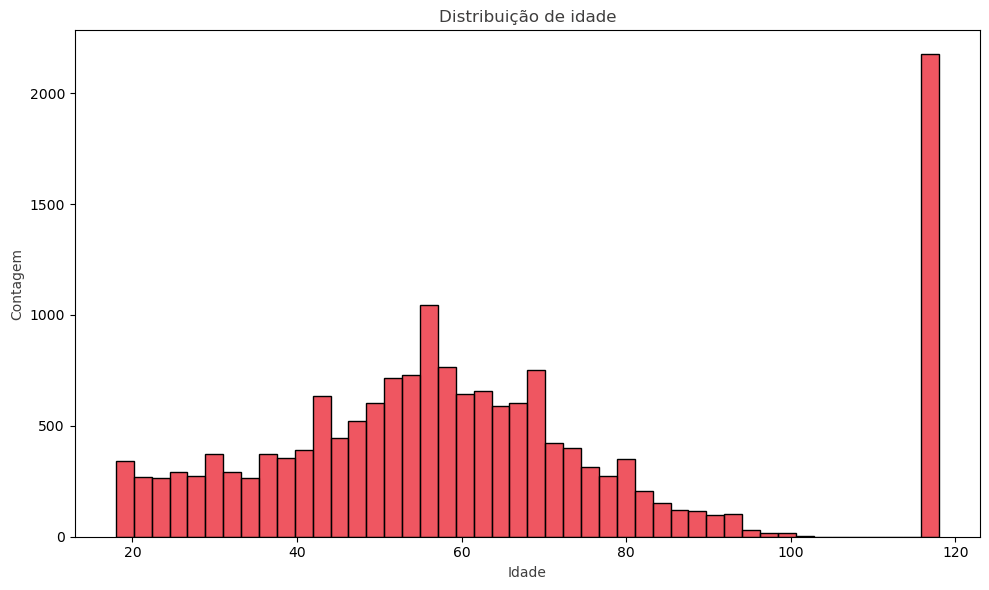

In [11]:
data_visualizer.plot_histogram_age()

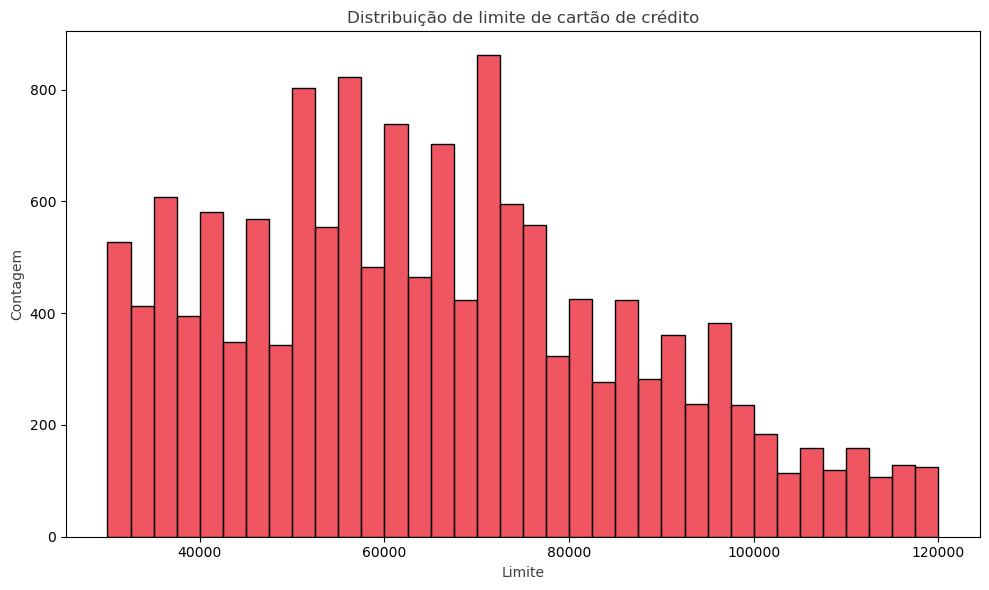

In [12]:
data_visualizer.plot_histogram_credit_card_limit()

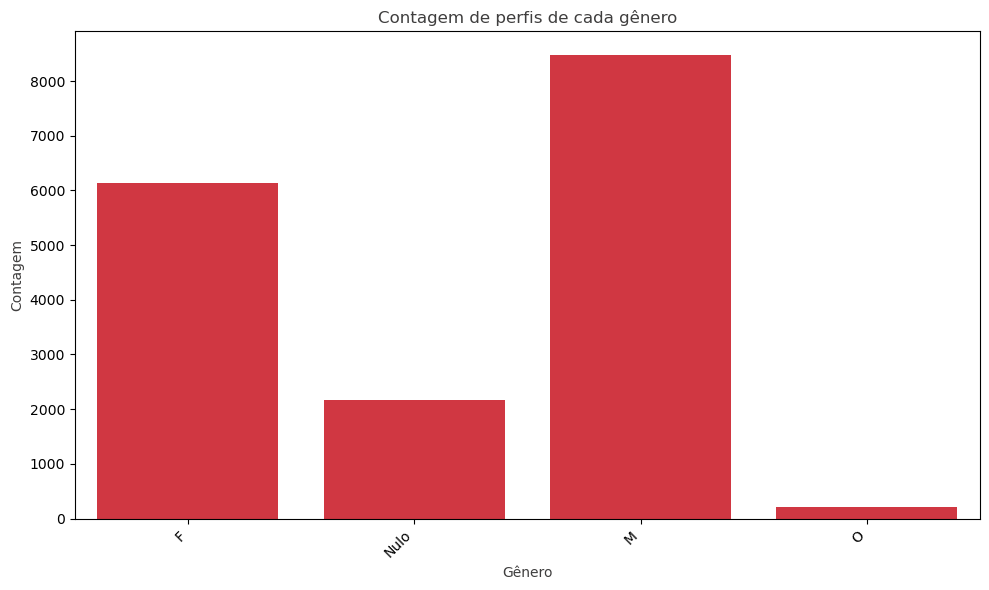

In [13]:
data_visualizer.plot_barplot_gender()

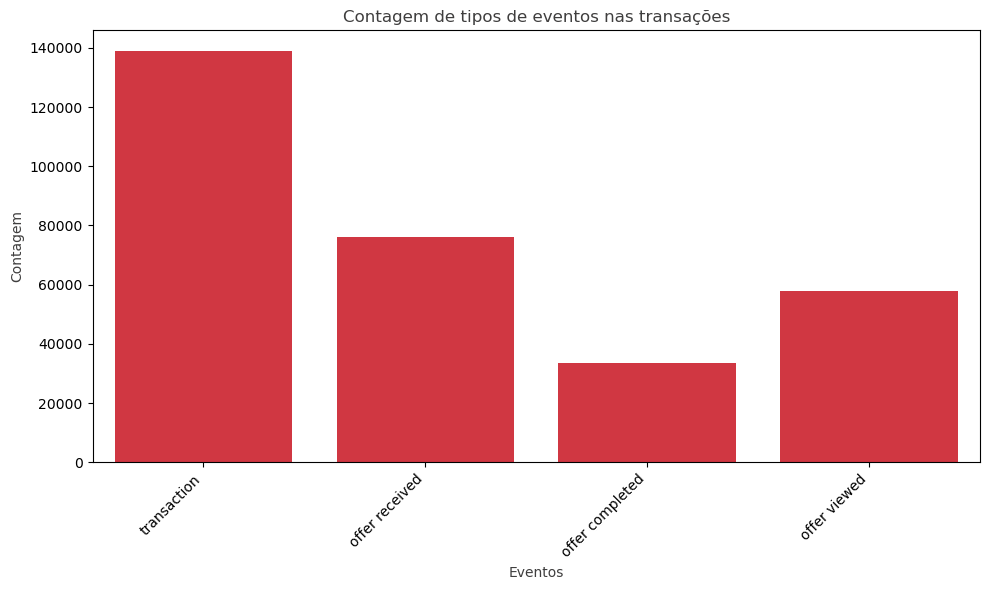

In [14]:
data_visualizer.plot_barplot_event()

## Bivariate Analysis 

/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:170: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.histplot(data=limit_age, x="credit_card_limit", hue="age_group", palette=IFOOD_PALETTE)


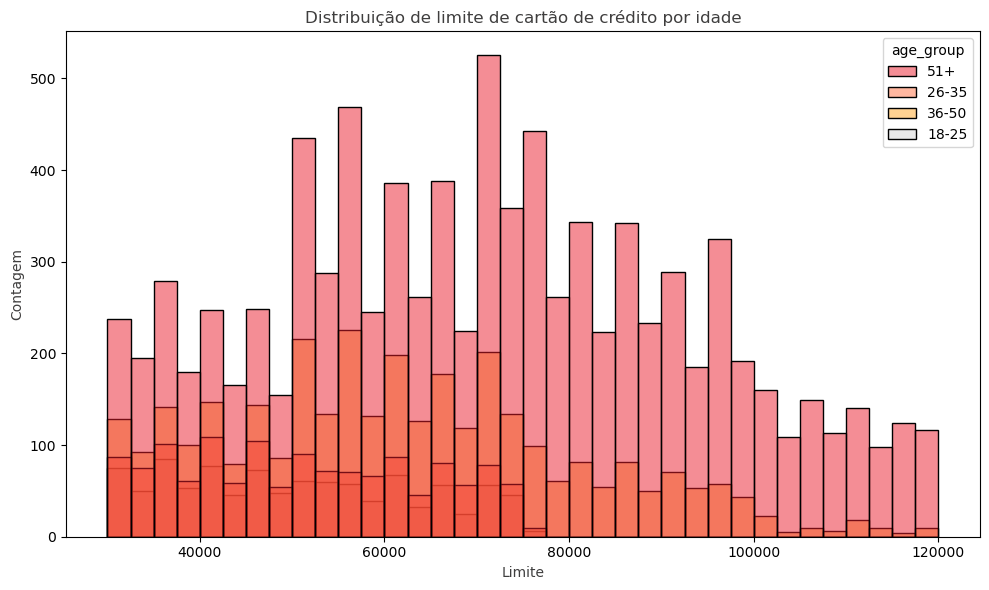

In [15]:
data_visualizer.plot_histogram_age_credit_card_limit()

/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  from pyspark.sql.functions import col, concat_ws, explode, when


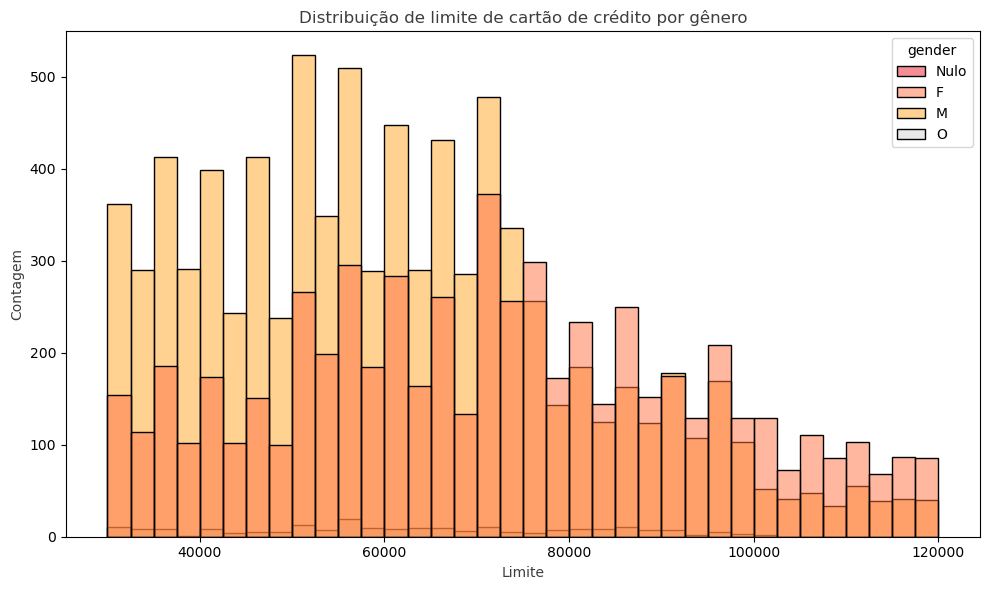

In [25]:
data_visualizer.plot_histogram_gender_credit_card_limit()